### Importing the libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split



In [29]:
def nan_handler(data):
    data_copy = data.copy()
    data_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
    for column in data_copy.columns:
        if data_copy[column].isnull().any():
            data_copy[column].fillna(data_copy[column].median(), inplace=True)
    return data_copy

Set visualization style

In [30]:
sns.set_theme(style='white', palette='viridis')

Set pandas display options

In [31]:
pd.set_option('display.max_rows', 100)
set_config(transform_output='pandas')
pd.options.mode.chained_assignment = None

### Downloading the data   

In [32]:
train_not_clean = pd.read_csv('/Users/charliemarchal/Desktop/optiver_trading/train.csv').drop(['row_id', 'time_id'], axis=1)
test_not_clean = pd.read_csv('/Users/charliemarchal/Desktop/optiver_trading/example_test_files/test.csv').drop(['row_id', 'time_id'], axis=1)

In [33]:
train = nan_handler(train_not_clean)
test = nan_handler(test_not_clean)

## Handling missing data

In [34]:
for column in train.columns:
    if train[column].isnull().any():
        train[column].fillna(train[column].median(), inplace=True)
for column in test.columns:
    if test[column].isnull().any():
        test[column].fillna(test[column].median(), inplace=True)

### Feature engineering

In [35]:
def create_features(data):
    # Time-based Features
    data['intraday_momentum'] = data['wap'].diff()  # Change in WAP between consecutive data points
    data['time_decay'] = data['seconds_in_bucket'] / (data['seconds_in_bucket'].max() + 1)

    # Price and Volume Imbalance Features
    data['bid_ask_spread'] = data['ask_price'] - data['bid_price']
    data['imbalance_ratio'] = data['imbalance_size'] / (data['matched_size'] + 1e-9)

    # Statistical Features
    data['wap_mean'] = data['wap'].rolling(window=5).mean()
    data['wap_std'] = data['wap'].rolling(window=5).std()

    # Relative Price Features
    data['price_vs_ma'] = data['wap'] / data['wap_mean']  # WAP relative to moving average

     # Auction Imbalance Indicators
    # Assuming imbalance_buy_sell_flag is already encoded appropriately

    # Lagged Features
    data['wap_lag_1'] = data['wap'].shift(1)

    # Non-linear Transformations
    data['log_bid_size'] = np.log1p(data['bid_size'])
    data['log_ask_size'] = np.log1p(data['ask_size'])

    # Remove any infinite values created by feature engineering
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    return data

train = create_features(train)
test = create_features(test)

# Fill any NaN values
train.fillna(method='bfill', inplace=True)
test.fillna(method='bfill', inplace=True)

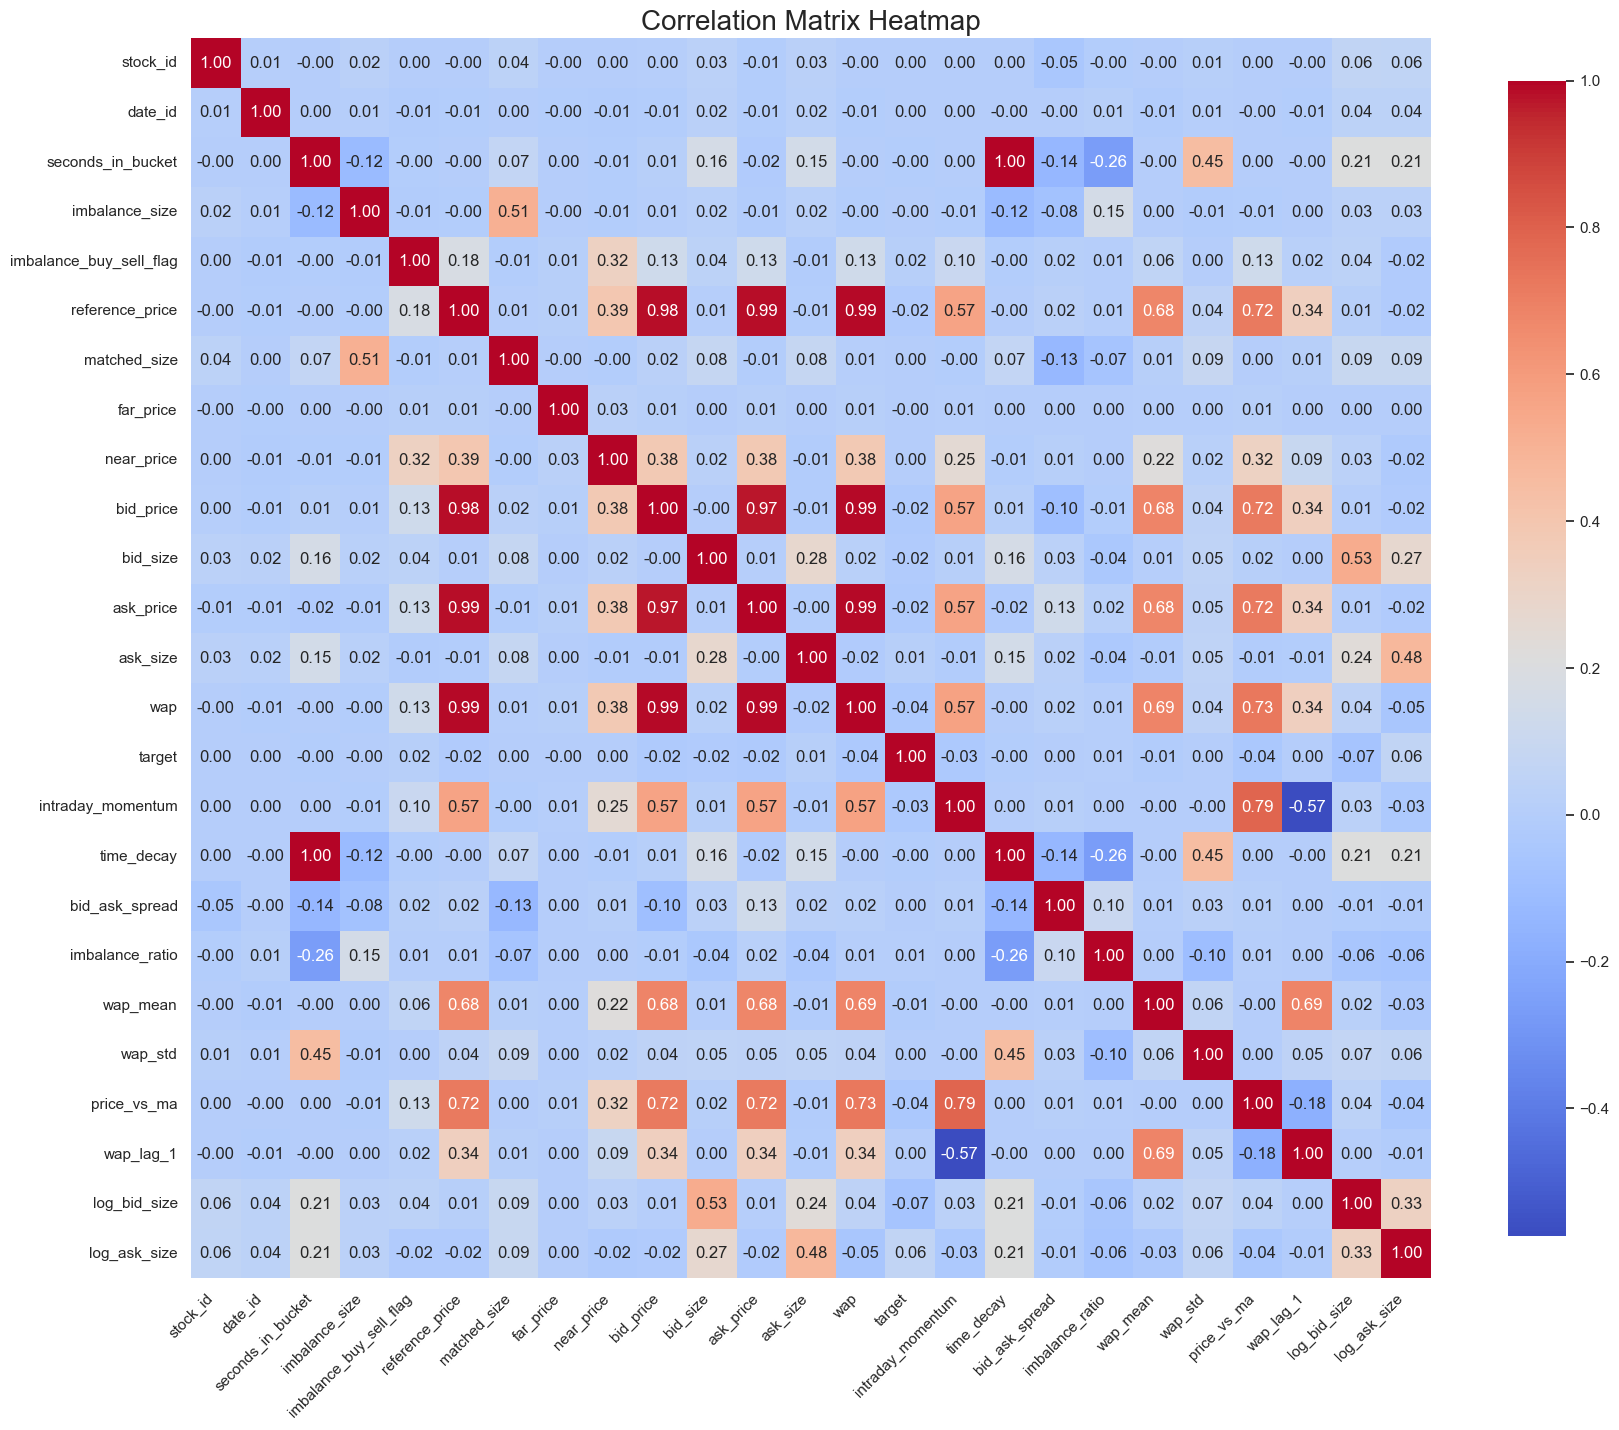

In [36]:
# Generate and display the correlation matrix heatmap
corr_matrix = train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .75})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.show()

In [37]:
X = train.drop(['target'], axis=1)
y = train['target']

In [38]:
# Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [40]:
# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=10,
    learning_rate=0.1,
    loss_function='RMSE',
    verbose=False,
    random_seed=42
)

# Create a pipeline with feature engineering and CatBoost regressor
pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(create_features)),
    ('regressor', catboost_model)
])

In [41]:
# Train the pipeline on the training set
pipeline.fit(X_train, y_train)

# Extract the CatBoost model from the pipeline
trained_catboost_model = pipeline.named_steps['regressor']

In [42]:
# Get feature importances
feature_importances = trained_catboost_model.get_feature_importance()
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", sorted_feature_importance)

Feature Importances:
                     Feature  Importance
16           bid_ask_spread   10.073675
6              matched_size    9.195592
1                   date_id    8.287544
15               time_decay    5.298341
2         seconds_in_bucket    4.965871
4   imbalance_buy_sell_flag    4.911710
3            imbalance_size    4.907456
0                  stock_id    4.904779
5           reference_price    4.123267
17          imbalance_ratio    4.048728
19                  wap_std    4.001517
8                near_price    3.431648
9                 bid_price    3.344650
18                 wap_mean    3.295310
11                ask_price    3.277081
13                      wap    3.095781
21                wap_lag_1    3.091065
10                 bid_size    2.524464
14        intraday_momentum    2.517336
12                 ask_size    2.474195
20              price_vs_ma    2.416832
22             log_bid_size    2.144106
23             log_ask_size    1.950077
7                 

In [43]:
# Evaluate the pipeline on the validation set
predictions = pipeline.predict(X_val)
evaluation_metric = mean_absolute_error(y_val, predictions)
print(f"Evaluation Metric (MAE): {evaluation_metric}")

Evaluation Metric (MAE): 6.024841076409158
